# 데이터 형식 잘 볼 수 있게 만들기

In [49]:
# Load the train dataset
# TODO Train Data 경로 입력

import pandas as pd
from ast import literal_eval


DATAPATH = '../../../data/v0/train.csv'
OUTPUTPATH = "../../../data/v0/check_train.txt"

dataset = pd.read_csv(DATAPATH) 

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)


with open(OUTPUTPATH, "w", encoding='utf-8') as f:
    for idx, row in df.iterrows():
        # paragraph를 '.' 기준으로 문장 나누기
        sentences = row['paragraph'].split('.')
        
        # 각 문장에 '\n' 추가
        wrapped_paragraph = '\n'.join([sentence.strip() + '.' for sentence in sentences if sentence.strip()])
        
        # choices를 한 줄씩 작성
        formatted_choices = '\n'.join([f"- {choice}" for choice in row['choices']])
        
        # 형식 지정
        formatted_row = (
            f"**ID** : {row['id']}\n"
            f"**지문**: \n{wrapped_paragraph}\n"
            f"**문제**: {row['question']}\n"
            f"**선지**: \n{formatted_choices}\n"
            f"**정답**: {row['answer']}\n\n"
        )

        # 파일에 쓰기
        f.write(formatted_row)

print("Data saved successfully!")

Data saved successfully!


# EDA 시작!!
- 중복 데이터 확인 및 제거
- url 혹은 이상한 문자 확인 
- 지문, 질문, 선지 길이 확인
- 선지 분포 확인


### 중복 데이터 확인 및 제거
- 각 칼럼에 대해서 확인 
- 중복 데이터는 지문 혹은 질문만이 아니라 (지문, 질문) 쌍으로 확인

In [50]:
for col in df.columns :
    print(f"{col} : {df.duplicated([col]).sum()}")

id : 0
paragraph : 160
question : 46
choices : 9
answer : 2026
question_plus : 2030


In [51]:
# choices의 중복 값을 확인한 결과 중복 아닌 것으로 판단됨.
col = 'choices'
df[df.duplicated([col])][col].tolist()

[['원주민들을 기독교로 개종', '부의 축적', '개인적 영광', '새 친구 찾기'],
 ['균형 물가 수준은 증가하는 반면 균형 산출량은 감소한다.',
  '균형 물가 수준은 감소하는 반면 균형 산출량은 증가한다.',
  '균형 물가 수준과 산출량이 증가한다.',
  '균형 물가 수준과 산출량이 감소한다.'],
 ['경기적 실업', '구조적 실업', '계절적 실업', '마찰적 실업'],
 ['고정관념', '기본적 귀인 오류', '단순노출효과', '호혜성 규범'],
 ['25세', '29세', '30세', '35세', '40세'],
 ['1%', '2%', '3%', '4%', '5%'],
 ['2015년', '2016년', '2017년', '2018년', '2019년'],
 ['2016년', '2017년', '2018년', '2019년', '2020년'],
 ['노무현 정부', '이명박 정부', '박근혜 정부', '문재인 정부', '윤석열 정부']]

In [52]:
# 지문 동일하다는거 직접 눈으로 판단
# duplicated_paragraph_set = set(df[df.duplicated('paragraph')]['paragraph'].tolist())
# with open("../../../data/v0/check_duplicate.txt", "w") as f:
#     for paragraph in duplicated_paragraph_set :
#         f.write("\n\n##########################\n")
#         same_paragraph_df = df[df['paragraph'] == paragraph] 
#         for idx, row in same_paragraph_df.iterrows() :
#             sentences = row['paragraph'].split('.')
        
#             # 각 문장에 '\n' 추가
#             wrapped_paragraph = '\n'.join([sentence.strip() + '.' for sentence in sentences if sentence.strip()])
            
#             # choices를 한 줄씩 작성
#             formatted_choices = ", ".join(row['choices'])
            
#             # 형식 지정
#             formatted_row = (
#                 f"**ID** : {row['id']}\n"
#                 f"**지문**: \n{wrapped_paragraph}\n"
#                 f"**문제**: {row['question']}\n"
#                 f"**선지**: \n{formatted_choices}\n"
#                 f"**정답**: {row['answer']}\n\n"
#             )
#             f.write(formatted_row)

In [53]:
duplicated_paragraph_set = set(df[df.duplicated('paragraph')]['paragraph'].tolist())
print(f"동일한 지문 개수: {len(duplicated_paragraph_set)}")

with open("../../../data/v0/real_check_duplicate.txt", "w") as f:
    duplicated_list = []
    for paragraph in duplicated_paragraph_set :
        same_paragraph_df = df[df['paragraph'] == paragraph]
        questions_set = set(df[df['paragraph'] == paragraph]['question'].tolist())
            
        if len(questions_set) != len(same_paragraph_df):
            f.write("##############Same Question Dataset!!##########################\n")
            for idx, row in same_paragraph_df.iterrows():
                f.write(row['id'])
                f.write("\n")
                f.write(str(row['paragraph']))
                f.write("\n")
                f.write(row['question'])
                f.write("\n")
                f.write(", ".join(row['choices']))
                f.write("\n")
                f.write(str(row['answer']))
                f.write("\n\n")
            duplicated_list.append(same_paragraph_df['id'].tolist())

print(f"질문까지 동일한 지문 수: {len(duplicated_list)}")
for i in duplicated_list :
    print(i)
# 제거할 id : []

동일한 지문 개수: 122
질문까지 동일한 지문 수: 5
['generation-for-nlp-449', 'generation-for-nlp-507']
['generation-for-nlp-426', 'generation-for-nlp-436']
['generation-for-nlp-819', 'generation-for-nlp-884']
['generation-for-nlp-461', 'generation-for-nlp-482']
['generation-for-nlp-463', 'generation-for-nlp-498']


In [54]:
# 잘못된 선지 제거 : 5개 
wrong_choices_ids = ['generation-for-nlp-498',
                     'generation-for-nlp-482',
                     'generation-for-nlp-507',
                     'generation-for-nlp-426',
                     'generation-for-nlp-884',
                     # 추가로 참고한 것들 https://stages.ai/en/competitions/330/board/community/post/2883  
                     'generation-for-nlp-434',
                     'generation-for-nlp-466',
                     'generation-for-nlp-480',
                     'generation-for-nlp-495',
                     'generation-for-nlp-509',
                     'generation-for-nlp-512'
                     ]

print(f"잘못된 선지 데이터 개수 : {len(wrong_choices_ids)}")
print(f"삭제 전 데이터 수 : {len(df)}")
df = df[~df['id'].isin(wrong_choices_ids)].reset_index(drop=True)
print(f"삭제 후 데이터 수 : {len(df)}")

잘못된 선지 데이터 개수 : 11
삭제 전 데이터 수 : 2031
삭제 후 데이터 수 : 2020


### url 및 이메일
- 기사 데이터도 있는데, 작성한 기자의 이메일 정보가 있어 조금이라도 context length 길이 줄여주고자 있는지 확인함

In [55]:
import re

# 이메일 추출을 위한 정규식
email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'

email_ids = []
for idx, row in df.iterrows() :
    emails = re.findall(email_pattern, row['paragraph'])
    if len(emails) > 0 :
        email_ids.append(row['id'])

print(f"이메일 있는 지문 개수: {len(email_ids)}")
email_ids

이메일 있는 지문 개수: 27


['generation-for-nlp-1478',
 'generation-for-nlp-1768',
 'generation-for-nlp-1778',
 'generation-for-nlp-1817',
 'generation-for-nlp-1841',
 'generation-for-nlp-1852',
 'generation-for-nlp-1873',
 'generation-for-nlp-1908',
 'generation-for-nlp-1930',
 'generation-for-nlp-1987',
 'generation-for-nlp-2114',
 'generation-for-nlp-2152',
 'generation-for-nlp-2217',
 'generation-for-nlp-2225',
 'generation-for-nlp-2267',
 'generation-for-nlp-2297',
 'generation-for-nlp-2467',
 'generation-for-nlp-2468',
 'generation-for-nlp-2517',
 'generation-for-nlp-2575',
 'generation-for-nlp-2580',
 'generation-for-nlp-2583',
 'generation-for-nlp-2618',
 'generation-for-nlp-2690',
 'generation-for-nlp-2746',
 'generation-for-nlp-2852',
 'generation-for-nlp-2853']

In [56]:
# 실제 이메일이 있나 확인
import random

random_idx = random.randint(0, len(email_ids)-1)

paragraph = df[df['id'] == email_ids[random_idx]]['paragraph'].values[0].split(".")
for p in paragraph :
    print(p)


서울 대부분 지역에서 재개발·재건축 등 주택정비사업이 지지부진한 데 반해 마포구 일대는 다른 모습이다
 교통여건이 양호하고 한강조망권을 갖춘 지역이 많다는 게 장점으로 부각되면서 올 들어서만 7곳에서 3685가구의 아파트를 분양했거나 공급을 앞두고 있다
 오는 19일부터 분양에 나서는 서울 합정동 ‘마포 한강 2차 푸르지오’도 한강조망권을 내세우는 대표적 재개발단지다
 대우건설이 지상 36층(2개동)으로 짓는 고층 주상복합(198가구)이다
 문장혁 분양소장은 “서울시가 지난해 한강변 건물 높이를 제한하는 ‘한강변 관리방향’을 발표하면서 30층 이상 고층 단지의 희소성이 한결 높아졌다”고 설명했다
 공급 가구의 67%인 132가구가 중소형(전용 83㎡)으로 설계됐다
이번 단지는 지난 3월 분양을 마친 ‘마포 한강 1차 푸르지오’ 바로 옆에 두 번째로 공급되는 아파트다
 지상 3층에는 입주자 전용 옥상정원이 마련된다
 1차 단지와 일체성을 위해 저층부 상가에서 다리를 통해 연결시켰다
 한강시민공원은 걸어서 다닐 수 있다
 선유도공원 월드컵공원 등 주변의 생활편의시설 이용도 수월하다
 분양가는 3
3㎡당 1900만원대로 인근 마포지역 단지들과 비슷한 수준이다
 발코니 확장은 물론 시스템 에어컨, 냉장고 등을 무상 제공하기 때문에 실분양가는 3
3㎡당 1800만원대 중반이란 게 회사 측 설명이다
 9층 이하 전용 83㎡형은 6억원, 110㎡형 14층 이하는 9억원 이하로 책정될 예정이다
 연말 이전에 계약하면 양도세 등을 면제받을 수 있다
 전용 83㎡형의 거실은 2개면이 외부와 맞닿아 있어서 채광과 한강조망이 특히 좋은 편이다
 또 건물 앞쪽에 방이 3개 배치되는 ‘3베이(거실-방-방)’로 설계됐다
 110㎡형은 맞통풍이 가능한 4베이(방-방-거실-방) 판상형 구조로 꾸며졌다
 발코니에는 추가로 다용도공간(알파룸공간)도 마련된다
 서울지하철 2·6호선 합정역이 단지 내 지하로 연결될 예정이어서 대중교통 여건이 좋은 편이다
 단지 앞쪽으로는 양화대교 북단과 직접 연결

In [57]:
# 이메일 제거

email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'

delete_email_num = 0
for idx in range(len(df)) :
    if len(re.findall(email_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(email_pattern, "", df.loc[idx, 'paragraph'])    
        delete_email_num += 1

print(f"이메일 삭제한 지문 수 : {delete_email_num}")

이메일 삭제한 지문 수 : 27


In [58]:
# url 패턴 추출

url_pattern = r'\b(?:https?|ftp|file|mailto|data|ws|wss|tel|sms|ssh|sftp):\/\/[^\s]+|\bwww\.[^\s]+|[^\s]+\.[a-z]{2,}'
url_ids = []
for idx, row in df.iterrows() :
    url = re.findall(url_pattern, row['paragraph'])
    if len(url) > 0 :
        url_ids.append(row['id'])


print(f"url 있다고 판단하는 지문 개수 : {len(url_ids)}")
url_ids

url 있다고 판단하는 지문 개수 : 23


['generation-for-nlp-1481',
 'generation-for-nlp-1483',
 'generation-for-nlp-1489',
 'generation-for-nlp-1505',
 'generation-for-nlp-1535',
 'generation-for-nlp-1619',
 'generation-for-nlp-1625',
 'generation-for-nlp-1677',
 'generation-for-nlp-1706',
 'generation-for-nlp-1835',
 'generation-for-nlp-1841',
 'generation-for-nlp-1890',
 'generation-for-nlp-1919',
 'generation-for-nlp-2005',
 'generation-for-nlp-2143',
 'generation-for-nlp-2447',
 'generation-for-nlp-2592',
 'generation-for-nlp-2607',
 'generation-for-nlp-2642',
 'generation-for-nlp-2665',
 'generation-for-nlp-2684',
 'generation-for-nlp-2735',
 'generation-for-nlp-2779']

In [59]:
# 실제 url 있나 확인
import random

random_idx = random.randint(0, len(url_ids)-1)

print(url_ids[random_idx])
paragraph = df[df['id'] == url_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 20):
    print(paragraph[i:i+40])

# generation-for-nlp-1625

generation-for-nlp-2779
서울시 산하 SH공사는 오는 18일부터 장기전세주택(시프트) 455가구를
터 장기전세주택(시프트) 455가구를 공급한다고 7일 발표했다.공급주택은
 공급한다고 7일 발표했다.공급주택은 시프트 전용 아파트인 양재동 양재1
 시프트 전용 아파트인 양재동 양재1단지(231가구)와 우면동 서초네이처
단지(231가구)와 우면동 서초네이처힐1단지(44가구) 등 건설형 시프트
힐1단지(44가구) 등 건설형 시프트 275가구, 래미안 도곡 진달래(1
 275가구, 래미안 도곡 진달래(14가구), 강서 한강 자이(81가구)
4가구), 강서 한강 자이(81가구) 등 매입형 시프트 95가구다. 또 
 등 매입형 시프트 95가구다. 또 기존 공급단지 중 입주자 퇴거와 계약
기존 공급단지 중 입주자 퇴거와 계약 취소 등으로 발생한 빈집 85가구(
 취소 등으로 발생한 빈집 85가구(32개 단지)도 포함됐다.시프트는 인
32개 단지)도 포함됐다.시프트는 인근 아파트 전세 시세의 75~80% 
근 아파트 전세 시세의 75~80% 수준으로 최장 20년(2년마다 재계약
수준으로 최장 20년(2년마다 재계약)까지 거주할 수 있다. 시프트 공급
)까지 거주할 수 있다. 시프트 공급 가격은 건설 및 매입 등 신규 물량
 가격은 건설 및 매입 등 신규 물량이 1억5600만원(강서 한강 자이 
이 1억5600만원(강서 한강 자이 59㎡)부터 3억6400만원(래미안 
59㎡)부터 3억6400만원(래미안 도곡 진달래 59㎡)까지다. 계획 취
도곡 진달래 59㎡)까지다. 계획 취소 등으로 인한 빈집은 8020만원(
소 등으로 인한 빈집은 8020만원(왕십리 모노퍼스 38㎡)부터 3억75
왕십리 모노퍼스 38㎡)부터 3억7500만원(래미안 퍼스티지 59㎡)까지
00만원(래미안 퍼스티지 59㎡)까지다.입주자 모집공고일 현재 서울시에 
다.입주자 모집공고일 현재 서울시에 거주하며 본인과 가구원 전원이 무주택
거주하며 본인과 가구원 전원이 무주택자인 청약저축(예금) 가

In [60]:
# url 제거

url_pattern = r'\b(?:https?|ftp|file|mailto|data|ws|wss|tel|sms|ssh|sftp):\/\/[^\s]+|\bwww\.[^\s]+|[^\s]+\.[a-z]{2,}'

delete_email_num = 0
for idx in range(len(df)) :
    if len(re.findall(url_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(url_pattern, "", df.loc[idx, 'paragraph'])    
        delete_email_num += 1

print(f"url 삭제한 지문 수 : {delete_email_num}")

url 삭제한 지문 수 : 23


In [61]:
# 전화번호 추출 예시

import re

# 전화번호 정규식
phone_pattern = r'\b(?:\+?\d{1,3})?[-.\s]?(?:\(?\d{1,3}\)?)?[-.\s]?\d{3,4}[-.\s]?\d{4}(?:#?\d{1,5})?\b'

# 테스트 데이터
text = """
1. 휴대전화: 010-1234-5678, 010 5678 1234, 010.1234.5678
2. 지역번호: 02-123-4567, 032 1234 5678, (031)123-4567
3. 국제전화: +82 10-1234-5678, +82 (2)123-4567, 82-10-1234-5678
4. 내선 번호: 02-1234-5678 ext.1234, 031-123-4567#123
5. 연속된 번호: 01012345678, 021234567
"""

# 정규식으로 전화번호 추출
phone_numbers = re.findall(phone_pattern, text)

# 결과 출력
print("추출된 전화번호:")
print(phone_numbers)


추출된 전화번호:
['010-1234-5678', '010 5678 1234', '010.1234.5678', '02-123-4567', '032 1234 5678', '031)123-4567', '82 10-1234-5678', '82 (2)123-4567', '82-10-1234-5678', '02-1234-5678', '031-123-4567#123', '01012345678', '021234567']


In [62]:
# 전화번호 패턴 추출

phone_pattern = r'\b(?:\+?\d{1,3})?[-.\s]?(?:\(?\d{1,3}\)?)?[-.\s]?\d{3,4}[-.\s]?\d{4}(?:#?\d{1,5})?\b'

phone_ids = []
for idx, row in df.iterrows() :
    phone = re.findall(phone_pattern, row['paragraph'])
    if len(phone) > 0 :
        phone_ids.append(row['id'])


print(f"폰번호 있다고 판단하는 지문 개수 : {len(phone_ids)}")
phone_ids

폰번호 있다고 판단하는 지문 개수 : 9


['generation-for-nlp-1501',
 'generation-for-nlp-1507',
 'generation-for-nlp-1610',
 'generation-for-nlp-1660',
 'generation-for-nlp-1841',
 'generation-for-nlp-1843',
 'generation-for-nlp-2468',
 'generation-for-nlp-2592',
 'generation-for-nlp-2614']

In [63]:
# 실제 폰번호 있나 확인
import random

random_idx = random.randint(0, len(phone_ids)-1)

print(phone_ids[random_idx])
paragraph = df[df['id'] == phone_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])


generation-for-nlp-2614
○서울 강남역 중심가 수익형 빌딩=환승역 출구 앞 대지 305㎡, 연면적
 1000㎡의 엘리베이터 갖춘 7층 건물. 유동인구 풍부한 상권으로 보증
금 5억원, 월 2860만원에 공실 없이 임대 중. 시세 이하 감정가(5
6억원) 수준 급매물. 57억원. (02)534-8878 서초 스카이중개
 이기종○서울 강남 역세권 수익형 빌딩=대지 252㎡, 연면적 600㎡의
 5층 근린생활시설 건물. 임차수요 풍부한 번화가로 보증금 3억4000만
원, 월 1350만원에 공실 없이 임대 중. 노후 대비 수익용으로 적합.
 사정상 급매. 31억원. (02)535-6709 서초 스카이중개 이기종
○경기 평택시 소사벌지구 신축 원룸=법원 인근 대지 258㎡, 연면적 4
56㎡의 4층 건물. 주인가구 있음. 임대 완료. 융자 4억2000만원,
 보증금 3억1200만원, 실투자 3억4800만원(조절 가능), 월 43
7만원. 삼성반도체KTX 지제역 수혜 지역. 10억8000만원. 010-
2911-5800 평택 한강공인 장호동○경기 용인시 동천동 이동통신 대리
점 상가=1만2000가구 아파트 대로변 사거리 코너 중심상가 1층 점포 
88㎡. 보증금 5000만원, 월 280만원에 장기 임대 중. 융자 2억
2000만원, 실투자 3억원, 수익률 9.1%. 안정적인 월세 수입 가능
. 5억7000만원. 010-5305-9797 용인 동문114 이창수○강
원 춘천시 남산면 전원주택지=설악IC에서 차로 15분 거리 밤벌유원지 내
 계획관리지역 토지 2644㎡. 홍천강변 조망이 우수한 부지로 대명리조트
, 팔봉산 인근. 3.3㎡당 35만원에 급매. (02)546-1259 강
남 유앤아이중개 박선아○충남 아산시 용화지구 신축 상가주택=대지 241㎡
, 연면적 413㎡. 융자 3억9000만원, 보증금 2억5400만원, 실
투자 1억2600만원에 월 288만원(이제 공제 후 151만원). 현대차
 등 인접해 임차수요 풍부. 7억7000만원. 010-337

In [64]:
# 폰번호 제거

phone_pattern = r'\b(?:\+?\d{1,3})?[-.\s]?(?:\(?\d{1,3}\)?)?[-.\s]?\d{3,4}[-.\s]?\d{4}(?:#?\d{1,5})?\b'

delete_email_num = 0
for idx in range(len(df)) :
    if len(re.findall(phone_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(phone_pattern, "", df.loc[idx, 'paragraph'])    
        delete_email_num += 1

print(f"폰번호 삭제한 지문 수 : {delete_email_num}")

폰번호 삭제한 지문 수 : 9


In [65]:
# 작성자 정보 정규식 (일반 문맥의 '기자' 제외)
author_pattern = r'\b(?:[가-힣]{2,4}(?:\s[가-힣]{2,4})?\s(?:기자|특파원|=[가-힣]{2,4}\s기자))\b'

# 지역 정보 정규식
region_pattern = r'\b([가-힣]{2,4})='


author_ids = []
for idx, row in df.iterrows() :
    author = re.findall(author_pattern, row['paragraph'])
    region = re.findall(region_pattern, row['paragraph'])
    if len(author) > 0 :
        author_ids.append(row['id'])


print(f"기자 정보 있다고 판단하는 지문 개수 : {len(author_ids)}")
author_ids        

기자 정보 있다고 판단하는 지문 개수 : 76


['generation-for-nlp-1455',
 'generation-for-nlp-1475',
 'generation-for-nlp-1478',
 'generation-for-nlp-1514',
 'generation-for-nlp-1515',
 'generation-for-nlp-1528',
 'generation-for-nlp-1532',
 'generation-for-nlp-1561',
 'generation-for-nlp-1574',
 'generation-for-nlp-1575',
 'generation-for-nlp-1582',
 'generation-for-nlp-1617',
 'generation-for-nlp-1628',
 'generation-for-nlp-1631',
 'generation-for-nlp-1641',
 'generation-for-nlp-1688',
 'generation-for-nlp-1701',
 'generation-for-nlp-1768',
 'generation-for-nlp-1817',
 'generation-for-nlp-1834',
 'generation-for-nlp-1844',
 'generation-for-nlp-1845',
 'generation-for-nlp-1852',
 'generation-for-nlp-1873',
 'generation-for-nlp-1908',
 'generation-for-nlp-1930',
 'generation-for-nlp-1961',
 'generation-for-nlp-1987',
 'generation-for-nlp-2061',
 'generation-for-nlp-2085',
 'generation-for-nlp-2114',
 'generation-for-nlp-2130',
 'generation-for-nlp-2142',
 'generation-for-nlp-2152',
 'generation-for-nlp-2159',
 'generation-for-nlp

In [66]:
# 실제 기자 있나 확인
import random

random_idx = random.randint(0, len(author_ids)-1)

print(author_ids[random_idx])
paragraph = df[df['id'] == author_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])


generation-for-nlp-2690
○개혁 조치 제한적 실행 가능성상하이자유무역구의 가장 큰 특징은 개방이다
. 서비스업 분야에서 외국 기업들도 중국 기업들과 평등하게 경쟁할 수 있
도록 규제를 대폭 완화했다. 상품과 자본의 국경도 없앴다. 상하이 당국은
 이를 위해 적절한 외환관리시스템을 구축하겠다고 밝혔다.반관영통신사인 중
국신문망은 이날 상하이자유무역구의 5대 특징으로 △외국인 투자에 네거티브
리스트 방식(금지규정 이외의 것은 모두 허용) 적용 △관세 및 비관세 장
벽 철폐 △서비스업 대외 개방 △금융개혁 △위안화 국제화 등을 들었다. 
이 통신은 “새 정부는 시장을 통한 효율적 자원 배치를 강조하고 있다”며
 “개방과 함께 국내 개혁도 더욱 가속화될 것”이라고 전했다. 자유무역구
관리위원회는 이날 첫 업무로 자유무역구에 지점 신청을 한 공상 농업 중국
 건설 교통 차오상 상하이 푸둥개발은행 등 8개 중국 은행과 씨티 싱가포
르개발은행 등 2곳의 외자은행 등 모두 10개 은행에 설립증명서를 발급했
다.전문가들은 정부가 비록 파격적인 조치들을 공포했지만 실제 구체적인 조
치들은 제한적으로 시행될 것으로 보고 있다. 중국은 금리 자유화, 위안화
 환전 자유 등의 금융개혁도 “리스크 통제를 전제로 한다”는 조건을 달았
다. 또 금리가 자유화된 자유무역구와 그렇지 않은 외부 지역과의 자금흐름
도 완전히 차단하는 방법을 강구 중이다. 당국이 상하이 자유무역지대를 분
리된 4곳의 보세구역으로 한정한 것도 외부 파장을 최소화하겠다는 의도로 
받아들여진다. 블룸버그통신은 “중국 정부는 자유무역구의 부작용으로 경제가
 타격을 받지 않도록 하면서도 개혁 실험을 너무 제약해 효율성을 떨어뜨리
지 않아야 하는 이중의 과제를 안고 있다”고 지적했다.전문가들은 상하이자
유무역구의 영향에 대해 엇갈린 반응을 내놓고 있다. 블룸버그가 17명의 
전문가를 대상으로 실시한 설문에서 8명은 상하이자유무역구가 앞으로 5년간
 중국의 국내총생산(GDP)에 거의 영향을 주지 못할 것이라

In [67]:
# 기자 제거

# 작성자 정보 정규식 (일반 문맥의 '기자' 제외)
author_pattern = r'\b(?:[가-힣]{2,4}(?:\s[가-힣]{2,4})?\s(?:기자|특파원|=[가-힣]{2,4}\s기자))\b'

# 지역 정보 정규식
region_pattern = r'\b([가-힣]{2,4})='

delete_email_num = 0
for idx in range(len(df)) :
    if len(re.findall(author_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(author_pattern, "", df.loc[idx, 'paragraph'])   
        df.loc[idx, 'paragraph'] = re.sub(region_pattern, "", df.loc[idx, 'paragraph']) 
        delete_email_num += 1

print(f"기자 삭제한 지문 수 : {delete_email_num}")

기자 삭제한 지문 수 : 76


### 특수문자(Reference by 정휘)

In [68]:
import re
from collections import defaultdict

non_chars = {}

def count_non_korean_english_chars(text):
    # 한글과 영어를 제외한 문자만 매칭하는 정규 표현식
    non_korean_english_chars = re.findall(r"[^가-힣a-zA-Z]", text)
    
    # 각 문자에 대해 개수를 증가
    for char in non_korean_english_chars:
        if char not in non_chars:
            non_chars[char] = 1
        else:
            non_chars[char] += 1

paragraph = df['paragraph']
for p in paragraph:
    count_non_korean_english_chars(p)


In [69]:
from pprint import pprint

sorted_non_chars = sorted(non_chars.items(),key=lambda x:-x[1])
for i, snon in enumerate(sorted_non_chars[:]):
    ch, ch_cnt = snon[0], snon[1]
    if (i+1) % 5 == 0:
        print(f"[{ch}, {ch_cnt}] ")
    else:
        print(f"[{ch}, {ch_cnt}] ",end=" ")

[ , 329821]  [., 24945]  [0, 11239]  [,, 10153]  [1, 9885] 
[2, 7382]  [), 4972]  [(, 4956]  [3, 4442]  [5, 3974] 
[“, 3505]  [4, 3475]  [”, 3440]  [’, 3243]  [‘, 3226] 
[9, 2824]  [6, 2775]  [8, 2754]  [7, 2621]  [%, 2592] 
[·, 1729]  [~, 724]  [", 551]  [㎡, 527]  [-, 398] 
[…, 391]  [○, 316]  [△, 302]  [
, 261]  [?, 240] 
[&, 214]  [▲, 192]  [', 187]  [/, 175]  [!, 128] 
[—, 127]  [[, 126]  [], 124]  [:, 120]  [>, 104] 
[<, 96]  [ , 90]  [《, 90]  [》, 90]  [=, 65] 
[㎞, 48]  [ｍ, 38]  [－, 36]  [*, 36]  [+, 34] 
[→, 33]  [‧, 28]  [㈜, 27]  [◇, 27]  [∙, 26] 
[#, 26]  [–, 23]  [㎝, 23]  [​, 23]  [▷, 19] 
[ㆍ, 16]  [『, 16]  [』, 16]  [×, 14]  [․, 13] 
[中, 13]  [「, 12]  [」, 12]  [§, 9]  [㎢, 9] 
[安, 9]  [▶, 9]  [三, 8]  [;, 8]  [㎏, 8] 
[平, 8]  [㎎, 8]  [◆, 8]  [■, 7]  [低, 7] 
[非, 7]  [對, 6]  [習, 6]  [近, 6]  [㉠, 5] 
[前, 5]  [〮, 5]  [李, 5]  [㎥, 5]  [反, 5] 
[㎾, 5]  [_, 5]  [行, 4]  [大, 4]  [詩, 4] 
[長, 4]  [强, 4]  [倍, 4]  [晋, 4]  [事, 4] 
[Ⅱ, 4]  [④, 4]  [路, 4]  [社, 4]  [正, 3] 
[ㄷ, 3]  [水, 3]  [㉡, 3]  [古

In [70]:
special_pattern = "○"

special_ids = []
for idx, row in df.iterrows() :
    special = re.findall(special_pattern, row['paragraph'])
    if len(special) > 0 :
        special_ids.append(row['id'])
print(f"{special_pattern}가(이) 포함된 지문 개수: {len(special_ids)}")
print("#############")

random_idx = random.randint(0, len(special_ids)-1)

print(special_ids[random_idx])
paragraph = df[df['id'] == special_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])

# 얜 잘 모르겠음 

○가(이) 포함된 지문 개수: 139
#############
generation-for-nlp-488
○왕이수(隋)에 군사를 청하는 글을 요청하자, ㉠은/는 “자기가 살기 위
해 남을 멸망시키는 것은 승려가 할 일이 아니나, 제가 대왕의 땅에 살면
서 수초(水草)를 먹고 있사 오니 명령을 따르겠습니다.”라고 하였다. ○
왕이 왕성을 짓고자 하여 ㉡에게 의견을 묻자, “비록 들판의 초가집에 살
아도 바른 도를 행하면 복업이 길어질 것이요, 그렇지 않으면 사람을 수고
롭게 하여 애써 성(城)을 만들지라도 역시 이익이 없을 것입니다.”라고 
하였다. －삼국사기－


In [71]:
# "○" 제거

special_pattern = "○"
delete_num = 0
for idx in range(len(df)) :
    if len(re.findall(special_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(special_pattern, "", df.loc[idx, 'paragraph'])    
        delete_num += 1

print(f"{special_pattern} 삭제한 지문 수 : {delete_num}")

○ 삭제한 지문 수 : 139


In [72]:
special_pattern = "△"

special_ids = []
for idx, row in df.iterrows() :
    special = re.findall(special_pattern, row['paragraph'])
    if len(special) > 0 :
        special_ids.append(row['id'])
print(f"{special_pattern}가(이) 포함된 지문 개수: {len(special_ids)}")
print("#############")

random_idx = random.randint(0, len(special_ids)-1)

print(special_ids[random_idx])
paragraph = df[df['id'] == special_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])

# 약간 , 느낌으로 사용


△가(이) 포함된 지문 개수: 66
#############
generation-for-nlp-2801
힘찬병원(대표원장 이수찬)이 의대진학을 희망하는 학생들에게 의료현장 체험
 기회를 제공하는 ‘제 10회 힘찬병원 청소년 여름 인턴십 프로그램’의 
수료식을 지난 26일 진행했다. ‘의사’라는 직업은 청소년들이 진로를 선
택하기 전까지 현장을 직접 체험하기 어려운 전문직이다. 힘찬병원은 실제 
병원 시스템과 거의 유사하게 인턴 체험을 할 수 있도록 도와 의료계에 종
사하고자 하는 학생들의 진로 선정에 도움을 주는 알찬 프로그램을 10년째
 이어오고 있다. 힘찬병원 이수찬 대표원장은 “의대 진학을 꿈꾸는 청소년
을 위한 직업 체험 인턴십 등 한국의 선진 의료를 이어갈 미래 꿈나무를 
키우는 것도 병원의 사회적 역할이라 생각된다”고 말했다. 힘찬병원 7개 
분원(강북, 강서, 목동, 부평, 인천, 부산, 창원)에 사전 모집으로 
선발된 중·고교생 36명은 7월 24일부터 3일 동안 현장 교육을 통해 
직업인 의사를 경험하는 시간을 가졌다. 책이나 인터넷으로 알고 있는 정보
에서 벗어나 다양한 의료 시스템을 체험해보면서 적성을 확인하고,정형외과,
 신경외과, 내과, 영상의학과, 마취과 등 각 전문의들의 세부적인 진료 
과정을 참관할 수 있는 기회를 제공했다. △의학강의 및 의대진학 과정에 
대한 의료진의 설명 △의료진 컨퍼런스, 병동 회진, 외래진료 체험 △진단
검사의학과〮영상의학과〮통증의학과〮내과의 검사 기기 체험 및 실습 △물리치
료, 수술실 체험 교육 등 실제 병원의 시스템을 보고 배우는 생생한 교육
의 장이 펼쳐졌다. 참가 학생 모두에게는 수료증과 함께 본인 이름이 새겨
진 의사 가운도 선물로 증정됐다.


In [73]:
# "△" 제거

special_pattern = "△"
delete_num = 0
for idx in range(len(df)) :
    if len(re.findall(special_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(special_pattern, ",", df.loc[idx, 'paragraph'])    
        delete_num += 1

print(f"{special_pattern} 삭제한 지문 수 : {delete_num}")

△ 삭제한 지문 수 : 66


In [74]:
special_pattern = "▲"

special_ids = []
for idx, row in df.iterrows() :
    special = re.findall(special_pattern, row['paragraph'])
    if len(special) > 0 :
        special_ids.append(row['id'])
print(f"{special_pattern}가(이) 포함된 지문 개수: {len(special_ids)}")
print("#############")

random_idx = random.randint(0, len(special_ids)-1)

print(special_ids[random_idx])
paragraph = df[df['id'] == special_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])

# 약간 , 느낌으로 사용 


▲가(이) 포함된 지문 개수: 28
#############
generation-for-nlp-2552
업스테이지(대표 김성훈)가 AI 분야의 직원을 공개 모집한다. 업스테이지
는 AI 기술을 통해 기업의 혁신이 가능한 부분을 파악하고 이에 필요한 
기본 AI 모델 및 시스템 구축을 포함한 컨설팅을 제공하는 스타트업으로 
‘모두를 위한 딥러닝’ 강의로 잘 알려진 글로벌 석학이자 전 네이버 클로
바 AI 헤드였던 김성훈 대표가 지난 10월 설립했다. 또한, 네이버 V
isual AI / OCR 팀에서 세계적인 성과를 낸 이활석 CTO, 세
계 최고의 번역기 파파고의 모델팀을 이끌었던 박은정 CSO를 비롯해 전 
카카오 AI 팀장 김재범, 캐글 전 세계 랭킹 12위의 그랜드 마스터 김
상훈, 엔비디아 AI 교육 및 개발 마케팅 담당의 손해인 등이 합류했다.
 그리고 NYU 조경현 교수와 홍콩과기대 Lei Chen 교수 등이 참여
하는 등 전 세계적인 AI 인력들이 업스테이지로 합류하고 있다. 업스테이
지의 인재 모집 분야는 ▲소프트웨어 엔지니어(Software engine
er - Back-end, Front-end, Machine learni
ng)▲AI 연구 엔지니어 (AI research engineer) ▲히
어로즈(Heroes) ▲AI 글로벌 레지던시(AI global resid
ency) 등이다. 업스테이지는 이번 모집에서 뛰어난 역량의 인재를 영입
하는 데 심혈을 기울일 예정이다. 일반 기업 채용과 차별화된 직무 영역인
 ‘히어로즈(Heroes)’라는 특별 직무를 추가했다. 히어로즈는 AI 
시대에 꼭 필요한 일들을 개척해 나가며, 기존의 직무로는 한정 지을 수 
없는 창의적인 업무를 수행한다. AI 인재 발굴, 인재 영입, 팀 빌딩부
터 AI 문제 세팅, 코어 프로덕트 개발, 비즈니스 전략 구축, 실제 서
비스 제작까지 업무에 대한 표현은 익숙하지만 AI 비즈니스에서 해당 업무
를 진행할 때는 이전과 다른 도전들을 맞닥뜨리게 되는데 이를 도전 정신으

In [75]:
# "▲" 제거

special_pattern = "▲"
delete_num = 0
for idx in range(len(df)) :
    if len(re.findall(special_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(special_pattern, ",", df.loc[idx, 'paragraph'])    
        delete_num += 1

print(f"{special_pattern} 삭제한 지문 수 : {delete_num}")

▲ 삭제한 지문 수 : 28


In [76]:
special_pattern = "㈜"

special_ids = []
for idx, row in df.iterrows() :
    special = re.findall(special_pattern, row['paragraph'])
    if len(special) > 0 :
        special_ids.append(row['id'])
print(f"{special_pattern}가(이) 포함된 지문 개수: {len(special_ids)}")
print("#############")

random_idx = random.randint(0, len(special_ids)-1)

print(special_ids[random_idx])
paragraph = df[df['id'] == special_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])



㈜가(이) 포함된 지문 개수: 18
#############
generation-for-nlp-2795
㈜에이치이엠(대표 지요셉)이 장내미생물-대사체 연구서비스 및 공정에 대한
 연구, 분석, 운영, 영업 및 고객관리 부문에서 ISO 9001(품질경
영시스템) 인증을 취득했다고 22일 밝혔다. ISO 9001은 국제표준화
기구에서 제정·시행하는 품질경영시스템에 대한 표준 규격으로, 제품 및 서
비스의 전 생산 과정에 걸친 품질경영시스템 수준을 평가해 인증해주는 제도
이다. 현재 에이치이엠은 장내 미생물 연구를 기반으로 하는 마이크로바이옴
 기업이다. 특히, 인간의 장과 비슷한 환경을 형성하여 가장 적합한 맞춤
형 솔루션을 찾아주는 국내 최초 PMAS 기술을 가지고 있다. 균주 생산
부터 분석 및 서비스 판매까지 사업의 모든 과정을 수행할 수 있는 인력과
 시설이 완비되어 있으며 장내 미생물 기반 혁신 신약 개발에 박차를 가하
고 있다. 에이치이엠은 체계적인 시스템으로 전문성과 우수성을 입증받기 위
해 ISO 9001 인증 획득을 준비해왔다. 이번 국제 인증으로 글로벌 
시장에서 대외 신뢰도가 한층 제고될 것으로 기대된다. 에이치이엠 관계자는
 “ISO 9001 인증을 획득하면서 관련 업계와 고객들에게 신뢰도를 높
이게 됐다.”며 “앞으로도 고객이 만족하고 믿을 수 있는 개인 맞춤형 마
이크로바이옴 분석 및 솔루션 서비스에 최선을 다할 것”이라고 말했다. 한
편 에이치이엠은 2020년도 중소벤처기업부 창업진흥원 창업도약패키지 지원
 사업에 선정되어 주관기관 경기창조경제혁신센터의 사업화 지원, 멘토링 등
 전문 맞춤 지원을 받고 있다.


In [77]:
# "㈜" 제거

special_pattern = "㈜"
delete_num = 0
for idx in range(len(df)) :
    if len(re.findall(special_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(special_pattern, "", df.loc[idx, 'paragraph'])    
        delete_num += 1

print(f"{special_pattern} 삭제한 지문 수 : {delete_num}")

㈜ 삭제한 지문 수 : 18


In [78]:
special_pattern = "◇"

special_ids = []
for idx, row in df.iterrows() :
    special = re.findall(special_pattern, row['paragraph'])
    if len(special) > 0 :
        special_ids.append(row['id'])
print(f"{special_pattern}가(이) 포함된 지문 개수: {len(special_ids)}")
print("#############")

random_idx = random.randint(0, len(special_ids)-1)

print(special_ids[random_idx])
paragraph = df[df['id'] == special_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])



◇가(이) 포함된 지문 개수: 7
#############
generation-for-nlp-2718
‘가치’를 통해 분석한 경제 현상◇밈노믹스=‘밈(meme)’은 유전을 통
하지 않고 사회 속에서 세대 간 옮겨지는 문화 요소를 뜻하는 개념이다. 
저자는 밈을 경제학에 접목해 ‘시장’ 원리가 아닌 인간이 추구하는 ‘가치
’의 프리즘을 통해 경제 현상을 분석하고 미래 경제를 예측한다. 혼돈과 
질서의 소용돌이 속에서 변화하고 발전하는 경제 흐름을 인류의 문화적 진화
라는 독특한 관점에서 해석했다. (사이드 돌리바니 지음, 박세연 옮김, 
엘도라도, 444쪽, 1만8000원)唐詩 찾아 중국 삼만리◇중국, 당시의
 나라=김준연 고려대 중어중문학과 교수가 이백 두보 백거이 왕유 등이 지
은 당시(唐詩)의 흥취를 느끼기 위해 당나라 시대 지도를 들고 길을 나섰
다. 13개 성(省)에 산재한 수십 개의 시와 현을 찾아다니며 당시 20
0여수의 내력을 훑었다. 10여년간 1만2500㎞를 누빈 대장정의 기록이
다. 답사한 명승고적에서 직접 확인할 수 있는 시를 우선적으로 소개했다.
 (김준연 지음, 궁리, 652쪽, 2만8000원)클래식~팝 … 음악의 
본질◇리슨 투 디스=미국 음악 비평계를 선도적으로 이끌고 있는 저자가 클
래식과 팝의 경계를 넘나들며 작곡가, 지휘자, 피아니스트, 록밴드, 싱어
송라이터 등 다양한 음악가들의 자취를 따라가며 음악의 역사와 본질에 대해
 이야기한다. 음악이 인간의 복잡다단한 면을 어떻게 담아내고, 어떤 식으
로 살아남아 그 영역을 확장해 나가는지를 흥미롭게 풀어냈다. (알렉스 로
스 지음, 장호연 옮김, 뮤진트리, 524쪽, 2만5000원)세월을 요리
하는 식당◇백년식당=에세이 작가이자 요리사인 저자가 한국에서 50년 이상
 영업한 오래된 식당들의 철학과 삶, 추억이 깃든 음식을 소개한다. 주인
들의 기억을 끄집어내고 옛 문헌들을 찾아 ‘그 집’만의 특별함을 기록했다
. 청진옥 할매국밥 우래옥 등 저자가 찾은 전국 18곳 식당의 공통점은 


In [79]:
# "◇" 제거

special_pattern = "◇"
delete_num = 0
for idx in range(len(df)) :
    if len(re.findall(special_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(special_pattern, "", df.loc[idx, 'paragraph'])    
        delete_num += 1

print(f"{special_pattern} 삭제한 지문 수 : {delete_num}")

◇ 삭제한 지문 수 : 7


In [80]:
special_pattern = "▷"

special_ids = []
for idx, row in df.iterrows() :
    special = re.findall(special_pattern, row['paragraph'])
    if len(special) > 0 :
        special_ids.append(row['id'])
print(f"{special_pattern}가(이) 포함된 지문 개수: {len(special_ids)}")
print("#############")

random_idx = random.randint(0, len(special_ids)-1)

print(special_ids[random_idx])
paragraph = df[df['id'] == special_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])



▷가(이) 포함된 지문 개수: 4
#############
generation-for-nlp-1462
기업은행이 하반기 신입사원 220명을 채용한다. 원서마감은 오는 13일이
다. 마감 전날인 12일엔 서울 을지로 본사 15층에서 지원자들의 열정과
 도전정신을 보고 채용하는 ‘당신을 보여주세요!’란 ‘4분 자기PR’도 
진행한다. 채용마감을 앞두고 한창 채용설명회로 바쁜 노학진 기업은행 인사
부 차장(사진)을 만나 ‘자격증, 합숙면접, 필기시험’에 관해 물었다. 
노 차장은 “늘 고객을 대해야 하는 은행원에게 최고의 무기는 미소”라고 
말했다.▷자격증 유무가 합격을 좌우하나.“자격증이 없는 것보다 있는 지원
자가 유리한 건 사실이다. 다만 자격증을 비롯한 스펙은 참고사항일 뿐 합
격을 위한 절대기준은 아니다. 고(高)스펙이라는 것은 성실히 살아왔고 어
느 정도 우수인재라고 판단할 수 있다. 스펙이 부족하다면 이를 만회할 남
다른 열정과 자신만의 강점을 보여줘야 한다. 참고로 상반기 합격자 210
명 중 82명은 금융자격증 하나 없이 합격했다.”▷1박2일 합숙면접 준비
는 어떻게.“합숙면접은 팀별 과제, 집단토론 등을 통해 지원자의 마케팅 
역량, 팀워크, 조직적응력, 창의력, 표현력 등을 평가하는 과정이다. 면
접위원들은 지원자의 나이, 학력 등을 전혀 모른다. 1박2일간의 관찰평가
가 이뤄지기 때문에 억지로 자신의 이미지를 만든다든지 과도한 액션은 오히
려 어색해 보일 수 있다. 평소 자신의 성격을 그대로 보여주면서 자신만의
 강점을 어필하는 것이 중요하다. 더불어 열정, 적극성, 영업력 등 은행
원에게 필요한 자질을 보여주면 좋다.”▷필기시험 걱정을 많이 하는데.“필
기는 논술·약술과 직무능력 평가로 나눠진다. 평소 신문을 꾸준히 읽으면 
좋다. 논술·약술은 경제, 금융상식, 시사문제가 출제된다. 전문지식보다는
 예상 가능한 문제들이 출제되기에 너무 긴장할 필요는 없다. 논술은 자신
의 의견을 논리적으로 전개하는지가 가장 중요하다. 외부 논문을 그대로 모


In [81]:
# "▷" 제거

special_pattern = "▷"
delete_num = 0
for idx in range(len(df)) :
    if len(re.findall(special_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(special_pattern, "", df.loc[idx, 'paragraph'])    
        delete_num += 1

print(f"{special_pattern} 삭제한 지문 수 : {delete_num}")

▷ 삭제한 지문 수 : 4


In [82]:
special_pattern = "ㆍ"

special_ids = []
for idx, row in df.iterrows() :
    special = re.findall(special_pattern, row['paragraph'])
    if len(special) > 0 :
        special_ids.append(row['id'])
print(f"{special_pattern}가(이) 포함된 지문 개수: {len(special_ids)}")
print("#############")

random_idx = random.randint(0, len(special_ids)-1)

print(special_ids[random_idx])
paragraph = df[df['id'] == special_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])



ㆍ가(이) 포함된 지문 개수: 8
#############
generation-for-nlp-2127
교육감 선거 예비후보 등록이 2주째를 넘겼지만 서울과 경기는 예비후보가 
한 명도 등록하지 않아 관심이 쏠리고 있다. 현직 교육감의 정치권 진출설
과 보수 및 진보진영 모두 후보 단일화를 추진하는 등 상황이 복잡하게 전
개되면서 ‘오리무중(五里霧中)’에 빠졌다는 분석이다.정치권 외풍 거세져중
앙선거관리위원회는 16일 현재 전국 17개 시ㆍ도 교육감 선거에 등록한 
예비후보는 56명이라고 밝혔다. 이기용 현 교육감이 ‘4선 연임 제한’에
 걸려 출마하지 못하는 충북에 8명이 등록하고 부산·충남·제주 등에 각각
 6명이 예비후보로 나서는 등 상당수 지역에서 과열조짐을 보이고 있다.반
면 서울과 경기는 한 명도 등록하지 않아 대조를 보이고 있다. 서울과 경
기는 현직 교육감이 비교적 탄탄한 기반을 갖추고 있는데다 수도권 특성상 
정치권과의 교감이 중시되기 때문으로 분석된다. 문용린 서울교육감의 경우 
박근혜 대통령의 교육부문 대선 공약 마련에 기여하는 등 친분이 두터워 대
항마가 없다는 분석이 나온다. 그러나 문 교육감은 본인의 부인에도 불구하
고 차기 총리설이 불거진 데 이어 최근에는 여권 내부에서 “보수 성향으로
 보기 어렵다”는 반응도 나오고 있다.김무성 새누리당 의원 등 일부 강경
파는 문 교육감이 학생인권조례나 혁신학교 등 곽노현 전 교육감의 정책을 
폐지하는데 다소 소극적으로 대처하고 있다며 불만을 나타낸 것으로 알려졌다
. 지방선거 이후 문 교육감의 총리 기용을 포함한 개각이 이뤄지거나, 혹
은 여권 일부 강경파가 다른 보수 후보를 적극 천거하는 등 정치권의 ‘외
풍(外風)’에 따라 보수진영 서울교육감 후보가 요동칠 수 있다.김상곤 경
기교육감 역시 몇 차례 여론조사에서 대부분 선두권을 달리고 있지만 최근 
안철수신당 영입설과 함께 경기도지사 출마설이 꾸준히 나오고 있다. 그의 
정계 진출 여부에 따라 경기교육감 선거구도도 흔들릴 수 있다.논의만 무성


In [83]:
# "ㆍ" 제거

special_pattern = "ㆍ"
delete_num = 0
for idx in range(len(df)) :
    if len(re.findall(special_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(special_pattern, ",", df.loc[idx, 'paragraph'])    
        delete_num += 1

print(f"{special_pattern} 삭제한 지문 수 : {delete_num}")

ㆍ 삭제한 지문 수 : 8


In [84]:
special_pattern = "§"

special_ids = []
for idx, row in df.iterrows() :
    special = re.findall(special_pattern, row['paragraph'])
    if len(special) > 0 :
        special_ids.append(row['id'])
print(f"{special_pattern}가(이) 포함된 지문 개수: {len(special_ids)}")
print("#############")

random_idx = random.randint(0, len(special_ids)-1)

print(special_ids[random_idx])
paragraph = df[df['id'] == special_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])



§가(이) 포함된 지문 개수: 3
#############
generation-for-nlp-1049
"기혼 여성의 재산을 보다 효과적으로 보호하기 위한 법률: "§1. 앞으
로 결혼할 여성의 부동산, 결혼 시 그 부동산에서 나오는, 임대료, 토지
에서 나오는 수익, 이익은 남편의 단독 처분 대상이 되어서는 아니되며, 
남편의 채무에 대한 책임이 없으며, 마치 미혼 여성인 것처럼 단독으로 별
도의 재산을 계속 유지해야 한다. "§2. 현재 결혼한 여성의 부동산 및
 동산과 그에서 나오는 임대료, 수익, 이익은 남편에 의한 처분 대상이 
될 수 없으나, 종전에 계약한 남편의 빚에 책임을 지는 경우를 제외하고는
, 마치 미혼 여성인 것처럼 단독인 별도의 재산이다. "§3. 기혼 여성
은 남편이 아닌 다른 이로부터 부동산 및 동산을 포함해 그에 부속된 이권
이나 자산을 상속, 증여, 부여, 고안 또는 유증받아 단독 개별 사용이 
가능하며, 전달 및 고안할 수 있으며 부속된 임대료, 이득, 이익은 미혼
 여성과 동일한 방식과 효과를 갖는다. 이 재산은 남편이 처분할 수 없으
며 남편의 빚에 책임을 지지 않는다." —기혼 여성 재산법, 뉴욕 주(1
848)


In [85]:
# "§" 제거

special_pattern = "§"
delete_num = 0
for idx in range(len(df)) :
    if len(re.findall(special_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(special_pattern, "", df.loc[idx, 'paragraph'])    
        delete_num += 1

print(f"{special_pattern} 삭제한 지문 수 : {delete_num}")

§ 삭제한 지문 수 : 3


In [86]:
special_pattern = "▶"

special_ids = []
for idx, row in df.iterrows() :
    special = re.findall(special_pattern, row['paragraph'])
    if len(special) > 0 :
        special_ids.append(row['id'])
print(f"{special_pattern}가(이) 포함된 지문 개수: {len(special_ids)}")
print("#############")

random_idx = random.randint(0, len(special_ids)-1)

print(special_ids[random_idx])
paragraph = df[df['id'] == special_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])



▶가(이) 포함된 지문 개수: 9
#############
generation-for-nlp-2245
서울시가 보행공원으로 바뀌는 서울역고가도로를 대체할 새 고가도로를 건설한
다. 서울역 배후 주거지역인 중림동·만리동·서계동 일대의 노후주택을 재개
발하고, 중림동 가로변 시장을 현대화해 골목상권을 활성화한다. ▶본지 4
월16일자 A1·3면, 4월18일자 A1·4면 참조서울시는 이 같은 내용
을 담은 ‘서울역 일대 종합발전계획’을 7일 발표했다. 박원순 서울시장이
 지난 1월 발표한 서울역고가 공원화 등 ‘서울역 7017 프로젝트’를 
토대로, 그동안 수렴한 주민 의견을 반영한 것이다. 이건기 행정2부시장은
 이날 기자설명회에서 “하루 유동인구가 40만명에 이르는 서울의 관문이자
 중심인 서울역 일대 개발을 통해 쇠퇴한 지역경제에 활력을 불어넣겠다”고
 말했다.우선 시는 서울역 북쪽 철도부지를 소유한 코레일과 협의해 북부 
역세권의 조기 개발에 나선다. 시는 이달 중 코레일과 함께 태스크포스를 
구성해 건축 규모와 기능 등을 협의한 뒤 올해 하반기 민간사업자 공모에 
나설 계획이다. 서울역고가 공원화에 따른 왕복 4차선 대체도로는 북부 역
세권 개발과 병행해 건설한다.시는 대체도로가 마련되기 전까지 교통 혼잡을
 막기 위해 염천교를 통한 우회경로를 마련할 계획이다. 남대문시장 인근을
 지나는 시내버스 노선은 현재 12개에서 15개로 늘리고, 이 지역을 편
도로 운행하던 버스 일부를 왕복 운행하도록 했다. 이와 함께 남대문시장은
 2018년까지 50억원(국비 50%, 시비 50%)을 투입해 현대화한다
.그동안 개발이 지체됐던 중림동 만리동 서계동 등 서울역 배후지역도 대대
적으로 개발한다. 시는 중림동 가로상권을 활성화해 골목상권을 키울 계획이
다. 지하철 2호선 충정로역 인근 호박마을 등 저층 노후주거지 정비를 위
해 융자 등 재정지원 방안을 마련하고, 용적률 상향 등 인센티브를 제공해
 조속한 개발을 유도할 방침이다. 만리동에서 약현성당을 지나 서소문공원까


In [87]:
# "▶" 제거

special_pattern = "▶"
delete_num = 0
for idx in range(len(df)) :
    if len(re.findall(special_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(special_pattern, "", df.loc[idx, 'paragraph'])    
        delete_num += 1

print(f"{special_pattern} 삭제한 지문 수 : {delete_num}")

▶ 삭제한 지문 수 : 9


In [88]:
special_pattern = "◆"

special_ids = []
for idx, row in df.iterrows() :
    special = re.findall(special_pattern, row['paragraph'])
    if len(special) > 0 :
        special_ids.append(row['id'])
print(f"{special_pattern}가(이) 포함된 지문 개수: {len(special_ids)}")
print("#############")

random_idx = random.randint(0, len(special_ids)-1)

print(special_ids[random_idx])
paragraph = df[df['id'] == special_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])



◆가(이) 포함된 지문 개수: 4
#############
generation-for-nlp-1929
평균수명이 점차 늘어나며 100세 시대가 현실화되고 있다. 하지만 단순히
 수명만 늘어나는 것은 그만큼 질병 속에서 살아가야 하는 날이 더 늘어났
다는 의미이기도 하다. ‘활백시대(활발하게 활동하며 백세를 누린다는 의미
)’라는 말이 있듯이 건강하게 오래 사는 것이 중요하다. 특히 무릎건강은
 고령화 시대에 삶의 질을 결정하는 중요한 요소다. ‘걸어야 산다’는 말
처럼 노년층에 무릎통증으로 거동이 불편하게 되면 근력이 점점 부족하게 되
고, 움직이지 못하면 만성질환이 악화하는 데다 우울증까지 깊어지게 되는 
것이다. 따라서 무릎관절염으로 가까운 거리를 걷는 것조차 힘들고, 가만히
 앉아있어도 무릎이 쑤시며 잠을 설칠 정도로 통증이 심하다면 길어진 여생
을 건강하게 보내기 위해서는 인공관절수술을 적극적으로 고려해보는 것이 좋
다. 고령에는 마취나 부작용에 부담을 느껴 수술을 꺼릴 수 있지만 최근에
는 의학기술이 발달해 고령 환자도 안전하게 인공관절수술을 받고 건강한 노
년을 보낼 수 있다. ◆ 만성질환 있어도 내과 협진으로 안전한 수술 가능
 무릎 인공관절수술은 손상된 연골과 관절을 대신할 수 있는 인공관절을 삽
입하는 수술이다. 통증을 줄이고 관절 기능을 회복시킬 수 있어 극심한 통
증으로 일상생활이 힘들었던 환자들의 만족도가 높은 편이다. 하지만 노년의
 나이라면 관절염 외에도 고혈압, 당뇨, 심장질환 등 다른 만성질환을 가
지고 있는 경우가 많아 수술 중 발생하는 출혈, 각종 합병증, 수술 후 
더딘 회복 등이 부담스러울 수 있다. 하지만 만성질환이 있어도 정형외과 
전문의와 내과 전문의의 긴밀한 협진체계가 가능하다면 면밀한 진료와 사전검
사를 통해 안전하게 인공관절수술을 받을 수 있다. 관절염으로 활동에 제약
이 생기면 우울증, 체중증가, 근력감소 등은 물론 만성질환도 더욱 악화될
 수 있기 때문에 수술에 대한 부담으로 통증을 참고 견디기보다 전문의와 


In [89]:
# "◆" 제거

special_pattern = "◆"
delete_num = 0
for idx in range(len(df)) :
    if len(re.findall(special_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(special_pattern, "", df.loc[idx, 'paragraph'])    
        delete_num += 1

print(f"{special_pattern} 삭제한 지문 수 : {delete_num}")

◆ 삭제한 지문 수 : 4


In [90]:
special_pattern = "■"

special_ids = []
for idx, row in df.iterrows() :
    special = re.findall(special_pattern, row['paragraph'])
    if len(special) > 0 :
        special_ids.append(row['id'])
print(f"{special_pattern}가(이) 포함된 지문 개수: {len(special_ids)}")
print("#############")

random_idx = random.randint(0, len(special_ids)-1)

print(special_ids[random_idx])
paragraph = df[df['id'] == special_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])



■가(이) 포함된 지문 개수: 3
#############
generation-for-nlp-2165
우리 몸속의 다양한 생체반응에서 촉매반응을 담당하는 효소들은, 특정 분자
에 한정된 반응이나 낮은 안정성 등 약점 때문에 다양한 진단 및 치료에 
직접적으로 활용하기 어려운 한계가 있다. 많은 연구자들은 이러한 효소의 
특성을 보완하거나 생체 내에서 효소와 만나 시너지효과를 낼 수 있는 인공
촉매를 이용한다면, 질병을 진단하고 치료하는 다양한 방법이 나올 것으로 
기대하고 있다. 특히, 자기장과 같은 외부자극에 반응하는 인공촉매가 개발
될 경우 몸 밖에서 원격으로 생체반응을 제어할 수 있는 새로운 치료 방법
도 현실이 될 수 있다. POSTECH(포항공과대학교, 총장 김무환) 화
학과 이인수 교수 연구팀은 살아있는 세포 내에서 높은 촉매 효율을 보이는
 원격자극 감응형 인공촉매 “MAG-NER”를 개발했다. 이 연구는 나노
분야 국제학술지 ‘나노레터스(Nano Letters)’지 표지논문으로 발
표됐다. 연구팀은 세포 내 소기관인 소포(小胞)* 구조를 모사해, 속이 
빈 실리카 나노껍질의 내부에 산화철-나노입자와 팔라듐(Pd) 촉매를 가지
고 있는 자기-촉매 결합 나노반응기를 합성했다. MAG-NER가 교류 자
기장을 만나면, 내부의 산화철-나노입자가 자기장 유도 발열 현상을 일으키
며, 외부의 온도를 올리지 않으면서 팔라듐 촉매만을 활성화시키게 된다. 
연구팀은 MAG-NER를 살아있는 세포 안에 흡수시킨 후 교류자기장을 가
하는 실험을 통해 비(非)형광성 반응물을 형광성 생성물로 변화시키는 촉매
 반응을 높은 효율로 구현하는데 성공했다. 또, MAG-NER의 촉매가 
세포 내에서도 생체분자에 의해 오염되지 않고 오랜 기간 활성을 유지할 수
 있으며, 세포의 생존에 영향을 주지 않는 것도 확인했다. MAG-NER
를 활용하면 생체에 무해한 자기장을 이용해 세포 내에서 인공 분자를 합성
하거나 화학반응을 유도할 수 있어, 세포의 기능을 인위적으로 원격제어할 


In [91]:
# "■" 제거

special_pattern = "■"
delete_num = 0
for idx in range(len(df)) :
    if len(re.findall(special_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(special_pattern, "", df.loc[idx, 'paragraph'])    
        delete_num += 1

print(f"{special_pattern} 삭제한 지문 수 : {delete_num}")

■ 삭제한 지문 수 : 3


In [92]:
special_pattern = r'\n{2,}'

special_ids = []
for idx, row in df.iterrows() :
    special = re.findall(special_pattern, row['paragraph'])
    if len(special) > 0 :
        special_ids.append(row['id'])
print(f"{special_pattern}가(이) 포함된 지문 개수: {len(special_ids)}")
print("#############")

random_idx = random.randint(0, len(special_ids)-1)

print(special_ids[random_idx])
paragraph = df[df['id'] == special_ids[random_idx]]['paragraph'].values[0]
for i in range(0, len(paragraph), 40):
    print(paragraph[i:i+40])



\n{2,}가(이) 포함된 지문 개수: 3
#############
generation-for-nlp-1163
“불가능한 상황을 평화로운 시정으로 해결해야 한다면서 평화로운 시정을 계
속해서 거부하는 건 불가능한 요구입니다. 이러한 시정을 이행하는 자가 법
을 위반하고 있다고 말하는 것 역시 말이 되지 않습니다. 베르사유의 ‘명
령(Dikta)’은 우리에게 법이 아니기 때문입니다. 그들은 우리 머리에
 총구를 들이대며, 수백만 국민의 기아를 인질로 삼으며 서명을 강요했습니
다. 그리고 그렇게 어쩔 수 없이 서명한 이 서류는 엄숙한 법으로 선언되
었습니다.” 아돌프 히틀러, 독일제국의회에서의 연설, 1939년 9월 1
일

“우리는 항복하거나 패배하지 않을 것입니다. 우리는 끝까지 싸울 것
입니다. 우리는 프랑스에서 싸울 것입니다. 우리는 바다와 대양에서 싸울 
것입니다. 우리는 자신감과 힘을 길러 하늘에서 싸울 것입니다. 어떤 대가
를 치르더라도 우리의 땅을 지켜 낼 것입니다 우리는 해변에서 싸울 것입니
다. 우리는 상륙지점에서 싸울 것입니다. 우리는 들판과 거리에서 싸울 것
입니다. 우리는 언덕에서 싸울 것입니다. 우리는 절대로 항복하지 않을 것
입니다.” 윈스턴 처칠, 하원 연설, 1940년 6월 4일


In [93]:
# 개행문자 2번 이상 연속 제거

special_pattern = r'\n{2,}'
delete_num = 0
for idx in range(len(df)) :
    if len(re.findall(special_pattern, df.loc[idx, 'paragraph'])) > 0 :
        df.loc[idx, 'paragraph'] = re.sub(special_pattern, "\n", df.loc[idx, 'paragraph'])    
        delete_num += 1

print(f"{special_pattern} 삭제한 지문 수 : {delete_num}")

\n{2,} 삭제한 지문 수 : 3


In [94]:
# problems = []
# for idx, row in df.iterrows() :
#     dict_ = {'question' : row['question'],
#              'choices' : row['choices'],
#              'answer' : row['answer']}
#     problems.append(dict_)

# df['problems'] = problems
# df.drop(columns = ['question','choices','answer'], inplace = True)

# df.to_csv("../../../data/v0/first_clean_train.csv", index=False)

### 길이 파악

In [95]:
import numpy as np
# 글자 수 기반 문장길이 확인
paragraph = df['paragraph']
lens_prg = np.array([len(prg) for prg in paragraph])
print("문장 길이 평균 : {:.3f}".format(lens_prg.mean()))

문장 길이 평균 : 737.328


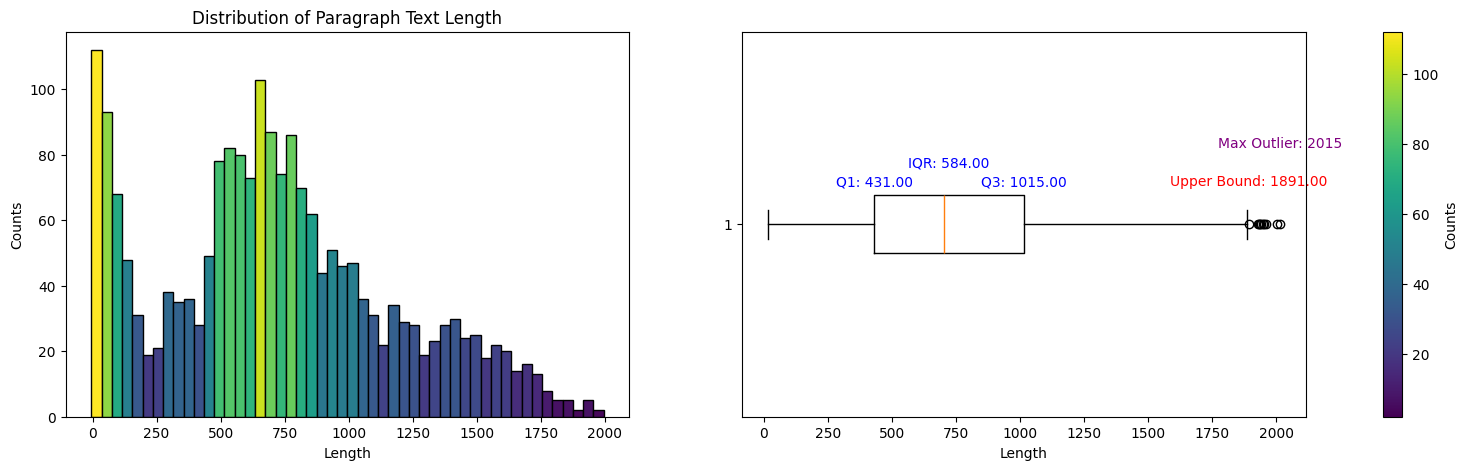

In [96]:
import matplotlib.pyplot as plt
# 히스토그램 데이터 생성
counts, bins = np.histogram(lens_prg, bins=50)

# 막대의 색상 적용
colors = plt.cm.viridis(counts / counts.max())  # Viridis 색상 맵 사용

# 플롯
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i in range(len(bins) - 1):
    ax[0].bar(bins[i], counts[i], width=bins[i + 1] - bins[i], color=colors[i], edgecolor="black")

ax[0].set_title("Distribution of Paragraph Text Length")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Length")

# 컬러바 추가
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=counts.min(), vmax=counts.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Counts")

# 박스 플롯 생성

Q1 = np.percentile(lens_prg, 25)
Q3 = np.percentile(lens_prg, 75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

ax[1].boxplot(lens_prg, vert=False)
ax[1].set_xlabel("Length")

ax[1].text(Q1, 1.1, f"Q1: {Q1:.2f}", color="blue", ha="center")
ax[1].text(Q3, 1.1, f"Q3: {Q3:.2f}", color="blue", ha="center")
ax[1].text(upper_bound, 1.1, f"Upper Bound: {upper_bound:.2f}", color="red", ha="center")
ax[1].text((Q1 + Q3) / 2, 1.15, f"IQR: {IQR:.2f}", color="blue", ha="center", fontsize=10)


outliers = lens_prg[lens_prg > upper_bound]
max_outlier = outliers.max() if len(outliers) > 0 else None  # Check if there are any outliers

if max_outlier is not None:
    ax[1].text(max_outlier, 1.2, f"Max Outlier: {max_outlier}", color="purple", ha="center", fontsize=10)



plt.show()

### 선지에 이상한 것들 파악 

In [97]:
""" 

generation-for-nlp-676,"대통령이 임기 마지막 2년을 앞두고 있음, 국제적 위기의 횟수와 심각성이 증가하고 있음, 의회와 백악관을 지배하는 정당이 서로 다름, 경제가 탄탄하고 대통령의 지지율이 높음.","{'question': '대통령은 보통 다음 중 어떤 상황에서 정치권력의 감소를 경험합니까?', 'choices': ['I만', 'I과 II만', 'I과 III만', 'II와 III만'], 'answer': 3}",
-> 이런거는 1, 2, 3이 각각 뭔지 알 수가 없음 

\xa0 포함된거는 풀수가 없게 만들어져있음 -> 근데 지문의 표 패턴을 알아서 학습하지 않을까?? 

"""

' \n\ngeneration-for-nlp-676,"대통령이 임기 마지막 2년을 앞두고 있음, 국제적 위기의 횟수와 심각성이 증가하고 있음, 의회와 백악관을 지배하는 정당이 서로 다름, 경제가 탄탄하고 대통령의 지지율이 높음.","{\'question\': \'대통령은 보통 다음 중 어떤 상황에서 정치권력의 감소를 경험합니까?\', \'choices\': [\'I만\', \'I과 II만\', \'I과 III만\', \'II와 III만\'], \'answer\': 3}",\n-> 이런거는 1, 2, 3이 각각 뭔지 알 수가 없음 \n\n\xa0 포함된거는 풀수가 없게 만들어져있음 -> 근데 지문의 표 패턴을 알아서 학습하지 않을까?? \n\n'

### 선지 분포 확인

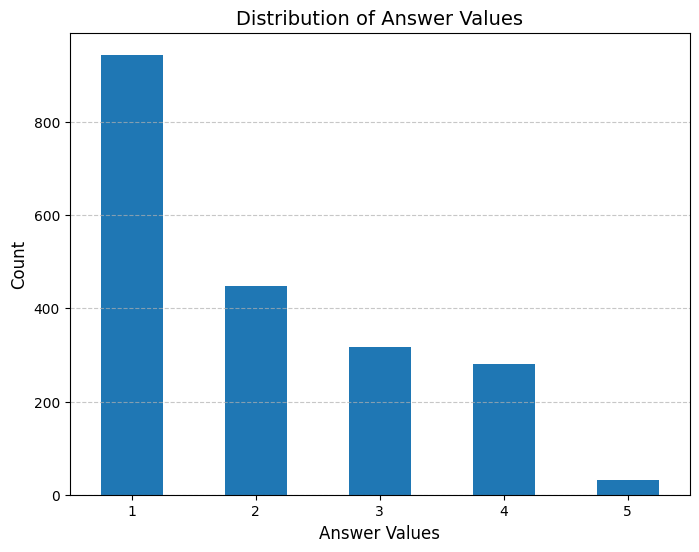

In [104]:
import matplotlib.pyplot as plt
value_counts = df['answer'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar')
plt.title('Distribution of Answer Values', fontsize=14)
plt.xlabel('Answer Values', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:

no_1 = []
no_2 = []
no_3 = []
no_4 = []
for idx in range(len(df)) :
    

# 주제 분류를 어떻게 할 것인가?



# FastText로 가능한거 해보기 


# 만약 FastText로 정제가 가능하면 이걸로 정제좀 하고 길이 확인 ㄱㄱ 
# 추가적으로 선지 분포도 확인 ㄱㄱ 이후 선지 좀 레이블 비슷하게 하는거 ㄱㄱ 